# Anomaly detection on SherlockML

Data taken from: https://www.kaggle.com/c/anomaly-detection-challenges

Requirements:
- XGBoost (apply the `install-xgboost` environment or run `pip install xgboost`)
- Keras (`pip install keras`)

In [32]:
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/project/anomaly-detection/modules/')

from anomaly_detection_tools import *

init_notebook_mode(connected=True)

## Data ingestion

In [2]:
data_df = read_training_data()

In [3]:
data_df.head()

,existing_account_status,duration_months,credit_history,purpose,credit_amount,savings_account_bonds,present_employment_since,installment_rate_percent,personal_status_gender,other_debtors_guarantors,...,property,age_years,other_installment_plans,housing,n_credits,job,n_people_maintenance,telephone,foreign_worker,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
3,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1
4,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,0


In [4]:
numerical_data_df = filter_numerical_only(data_df)

In [5]:
numerical_data_df.head()

,duration_months,credit_amount,installment_rate_percent,present_residence_since,age_years,n_credits,n_people_maintenance,label
0,6,1169,4,4,67,2,1,0
1,48,5951,2,2,22,1,1,1
2,42,7882,2,4,45,1,2,0
3,24,4870,3,4,53,2,2,1
4,36,6948,2,2,35,1,1,0


## Dimensional reduction

To see whether an unsupervised learning approach is possible, let's perform dimensional reduction on the data and see what we get.

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components=2)

In [8]:
X_red = pca.fit_transform(numerical_data_df.drop(['label'], axis=1))

In [9]:
X_red.shape

(500, 2)

In [10]:
Y = np.array(numerical_data_df['label']).reshape((-1,1))

In [11]:
X_red[Y[:,0]==0].shape, X_red[Y[:,0]==1].shape

((339, 2), (161, 2))

In [12]:
trace0 = go.Scatter(
    x = X_red[Y[:,0]==0][:,0],
    y = X_red[Y[:,0]==0][:,1],
    mode = 'markers',
    name = 'class 0'
)

trace1 = go.Scatter(
    x = X_red[Y[:,0]==1][:,0],
    y = X_red[Y[:,0]==1][:,1],
    mode = 'markers',
    name = 'class 1'
)

data = [trace0, trace1]

fig = go.Figure(data=data)

iplot(fig)

## Training an XGBoost classifier

Transform categorical features into numerical features using dummy variables.

In [13]:
data_df_dummies = pd.get_dummies(data_df)

data_df_dummies.shape

(500, 62)

Cross validation: split dataset into train and test data.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X = np.array(data_df_dummies.drop(['label'], axis=1))
Y = np.array(data_df_dummies['label'])

In [16]:
seed = 42
np.random.seed(seed)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

Train an XGBoost classifier.

In [18]:
from xgboost import XGBClassifier

In [19]:
xgbc = XGBClassifier()

In [20]:
xgbc.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Evaluate the XGBoost classifier on the test data

Compute the confusion matrix on the test data.

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Normalized confusion matrix
[[0.80701754 0.19298246]
 [0.58823529 0.41176471]]


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



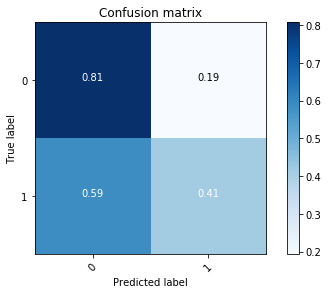

In [22]:
plot_confusion_matrix(confusion_matrix(Y_test, xgbc.predict(X_test)), [0,1], normalize=True)

## Train a neural network classifier

In [23]:
from keras.models import Sequential
from keras.layers import Dense

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


Define the graph.

In [24]:
model = Sequential()
model.add(Dense(10, input_shape=(X.shape[1],), activation='tanh'))

model.add(Dense(50, input_shape=(X.shape[1],), activation='sigmoid'))

model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
seed = 42
np.random.seed(seed)

In [26]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


Rescale the data.

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()

In [29]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Train the model on the scaled data.

In [30]:
model.fit(X_train_scaled, Y_train.reshape((-1,1)), epochs=300, verbose=0)

## Evaluate the neural network on the test data

Compute the confusion matrix on the test data.

Normalized confusion matrix
[[0.73684211 0.26315789]
 [0.43137255 0.56862745]]


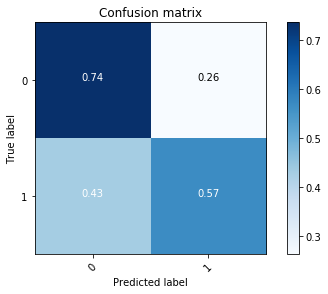

In [31]:
plot_confusion_matrix(confusion_matrix(Y_test, model.predict_classes(X_test_scaled)), [0,1], normalize=True)